# Fine-tuning Florence-2 on DocVQA

In this notebook, we will fine-tune Florence-2 by MSFT, a new vision language model capable of various tasks, on document question answering.

Let's start by installing the dependencies and loading the dataset.

In [ ]:
!pip install -q datasets flash_attn timm einops
!pip install datasets

In [2]:
MAX_CAPTION_LEN = 64

BATCH_SIZE =1

IMG_HEIGHT = 299
IMG_WIDTH = 299
IMG_CHANNELS = 3

### Loading the dataset

In [3]:
import tensorflow_datasets as tfds
import tensorflow as tf

GCS_DIR = "gs://asl-public/data/tensorflow_datasets/"
BUFFER_SIZE = 1000


def get_image_label(example):
    caption = example["captions"]["text"][0]  # only the first caption per image
    img = example["image"]
    img = tf.image.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    img = img / 255
    return {"image_tensor": img, "caption": caption}


trainds = tfds.load("coco_captions", split="train", data_dir=GCS_DIR)

trainds = trainds.map(
    get_image_label, num_parallel_calls=tf.data.AUTOTUNE
).shuffle(BUFFER_SIZE)
trainds = trainds.prefetch(buffer_size=tf.data.AUTOTUNE)

In [4]:
trainds

<_PrefetchDataset element_spec={'image_tensor': TensorSpec(shape=(299, 299, 3), dtype=tf.float32, name=None), 'caption': TensorSpec(shape=(), dtype=tf.string, name=None)}>

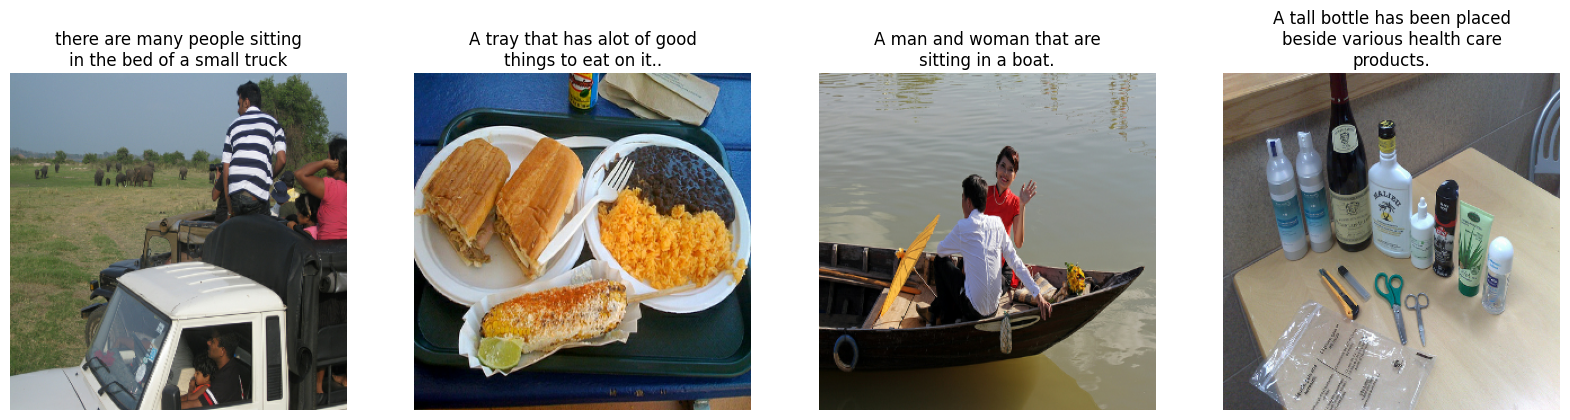

In [5]:
import matplotlib.pyplot as plt
from textwrap import wrap


f, ax = plt.subplots(1, 4, figsize=(20, 5))
for idx, data in enumerate(trainds.take(4)):
    ax[idx].imshow(data["image_tensor"].numpy())
    caption = "\n".join(wrap(data["caption"].numpy().decode("utf-8"), 30))
    ax[idx].set_title(caption)
    ax[idx].axis("off")

In [6]:
# from datasets import load_dataset

# data_vqa = load_dataset("HuggingFaceM4/DocumentVQA")

In [7]:
# data_vqa

In [8]:
# data_vqa['train'][15]

# <PIL.PngImagePlugin.PngImageFile image mode=L size=1695x2025>,

In [9]:
# data_vqa['train'][0]['image']

We can load the model using `AutoModelForCausalLM` and the processor using `AutoProcessor`  classes of transformers library. Note that we need to pass `trust_remote_code` as `True` since this model is not a transformers model.

In [12]:
from transformers import AutoModelForCausalLM, AutoProcessor
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForCausalLM.from_pretrained("microsoft/Florence-2-base-ft", trust_remote_code=True, revision='refs/pr/6').to(device)
processor = AutoProcessor.from_pretrained("microsoft/Florence-2-base-ft", trust_remote_code=True, revision='refs/pr/6')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [11]:
torch.cuda.empty_cache()

Let's do inference with our dataset first to see how the model performs already with our dataset before fine-tuning.

In [12]:
# Function to run the model on an example
def run_example(task_prompt, text_input, image):
    prompt = task_prompt + text_input

    # Ensure the image is in RGB mode
    if image.mode != "RGB":
        image = image.convert("RGB")

    inputs = processor(text=prompt, images=image, return_tensors="pt").to(device)
    generated_ids = model.generate(
        input_ids=inputs["input_ids"],
        pixel_values=inputs["pixel_values"],
        max_new_tokens=1024,
        num_beams=3
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(generated_text, task=task_prompt, image_size=(image.width, image.height))
    return parsed_answer


In [13]:
data['image_tensor'].shape

TensorShape([299, 299, 3])

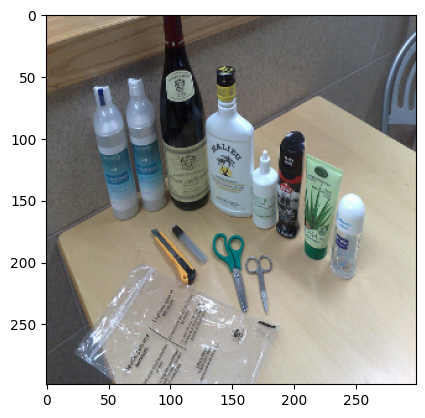

In [14]:
plt.imshow(data["image_tensor"].numpy())

<PIL.Image.Image image mode=RGB size=299x299 at 0x7DDFD976A8C0>


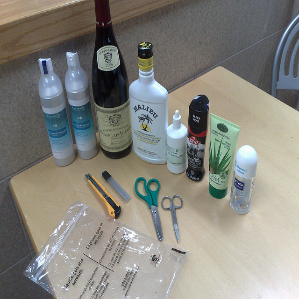

In [15]:
import numpy as np
from PIL import Image

# assuming data['image_tensor'] is your tensor
# and it's in the shape (299, 299, 3) with values in the range [0, 1] or [0, 255]

# Convert the tensor to a NumPy array
image_array = data['image_tensor'].numpy()

# If the values are in [0, 1], scale them to [0, 255]
if image_array.max() <= 1.0:
    image_array = (image_array * 255).astype(np.uint8)
else:
    image_array = image_array.astype(np.uint8)

# Convert the NumPy array to a PIL image
image = Image.fromarray(image_array, mode='RGB')

print(image)  # This should print: <PIL.Image.Image image mode=RGB size=299x299 at ...>
image

In [16]:
# function for converting the tensor to image
def tensor_to_image(tensor):
    # Convert the tensor to a NumPy array
    image_array = tensor.numpy()

    # If the values are in [0, 1], scale them to [0, 255]
    if image_array.max() <= 1.0:
        image_array = (image_array * 255).astype(np.uint8)
    else:
        image_array = image_array.astype(np.uint8)

    # Convert the NumPy array to a PIL image
    image = Image.fromarray(image_array, mode='RGB')

    return image


In [17]:
# import tensorflow as tf
# from datasets import Dataset
# from PIL import Image
# import numpy as np
# import io

# def transform_dataset(tf_dataset):
#     def generator():
#         for idx, item in enumerate(tf_dataset):
#             # Convert tensor to PIL Image
#             image_array = item['image_tensor'].numpy()
#             if image_array.max() <= 1.0:
#                 image_array = (image_array * 255).astype(np.uint8)
#             else:
#                 image_array = image_array.astype(np.uint8)

#             pil_image = Image.fromarray(image_array, mode='RGB')

#             # Convert PIL Image to bytes
#             img_byte_arr = io.BytesIO()
#             pil_image.save(img_byte_arr, format='PNG')
#             img_byte_arr = img_byte_arr.getvalue()

#             yield {
#                 'questionId': idx,  # Using index as questionId
#                 'question': 'Describe this image',  # Placeholder question
#                 'question_types': ['image_caption'],  # Placeholder question type
#                 'image': img_byte_arr,
#                 'docId': idx,  # Using index as docId
#                 'ucsf_document_id': f'doc_{idx}',  # Placeholder document id
#                 'ucsf_document_page_no': '1',  # Placeholder page number
#                 'answers': [item['caption'].numpy().decode('utf-8')]  # Using caption as answer
#             }

#     # Create Hugging Face dataset
#     hf_dataset = Dataset.from_generator(
#         generator,
#         features={
#             'questionId': tf.int32,
#             'question': tf.string,
#             'question_types': tf.string,
#             'image': tf.io.FixedLenFeature([], tf.string),
#             'docId': tf.int32,
#             'ucsf_document_id': tf.string,
#             'ucsf_document_page_no': tf.string,
#             'answers': tf.string,
#         }
#     )

#     return hf_dataset

# # Transform your dataset
# hf_trainds = transform_dataset(trainds)

# # Now you can use it similarly to the Hugging Face dataset
# print(hf_trainds)

# # To access an item:
# item = hf_trainds[0]
# print(item)

# # To display an image:
# import matplotlib.pyplot as plt

# def show_image(item):
#     image = Image.open(io.BytesIO(item['image']))
#     plt.imshow(image)
#     plt.title(item['answers'][0])
#     plt.axis('off')
#     plt.show()

# show_image(hf_trainds[0])

In [18]:
# import tensorflow as tf
# from datasets import Dataset
# from PIL import Image
# import numpy as np
# import io

# def process_tf_item(item):
#     # Convert tensor to PIL Image
#     image_array = item['image_tensor'].numpy()
#     if image_array.max() <= 1.0:
#         image_array = (image_array * 255).astype(np.uint8)
#     else:
#         image_array = image_array.astype(np.uint8)

#     pil_image = Image.fromarray(image_array, mode='RGB')

#     # Convert PIL Image to bytes
#     img_byte_arr = io.BytesIO()
#     pil_image.save(img_byte_arr, format='PNG')
#     img_byte_arr = img_byte_arr.getvalue()

#     return {
#         'image': img_byte_arr,
#         'caption': item['caption'].numpy().decode('utf-8')
#     }

# def transform_dataset(tf_dataset):
#     processed_data = []
#     for idx, item in enumerate(tf_dataset):
#         processed_item = process_tf_item(item)
#         processed_item.update({
#             'questionId': idx,
#             'question': 'Describe this image',
#             'question_types': ['image_caption'],
#             'docId': idx,
#             'ucsf_document_id': f'doc_{idx}',
#             'ucsf_document_page_no': '1',
#             'answers': [processed_item['caption']]
#         })
#         processed_data.append(processed_item)

#     # Create Hugging Face dataset
#     hf_dataset = Dataset.from_dict({
#         'questionId': [item['questionId'] for item in processed_data],
#         'question': [item['question'] for item in processed_data],
#         'question_types': [item['question_types'] for item in processed_data],
#         'image': [item['image'] for item in processed_data],
#         'docId': [item['docId'] for item in processed_data],
#         'ucsf_document_id': [item['ucsf_document_id'] for item in processed_data],
#         'ucsf_document_page_no': [item['ucsf_document_page_no'] for item in processed_data],
#         'answers': [item['answers'] for item in processed_data],
#     })

#     return hf_dataset

# # Transform your dataset
# hf_trainds = transform_dataset(trainds)

# # Now you can use it similarly to the Hugging Face dataset
# print(hf_trainds)

# # To access an item:
# item = hf_trainds[0]
# print(item)

# # To display an image:
# import matplotlib.pyplot as plt

# def show_image(item):
#     image = Image.open(io.BytesIO(item['image']))
#     plt.imshow(image)
#     plt.title(item['answers'][0])
#     plt.axis('off')
#     plt.show()

# show_image(hf_trainds[0])

In [19]:
# for idx in range(3):
#   print(run_example("DocVQA", 'What do you see in this image?', data['train'][idx]['image']))
#   display(data['train'][idx]['image'].resize([350, 350]))

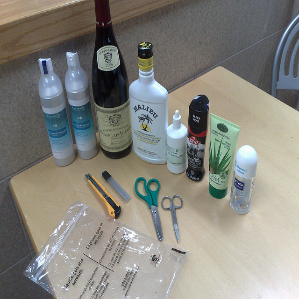

In [20]:
tensor_to_image(data['image_tensor'])

{'DocVQA': 'no'}


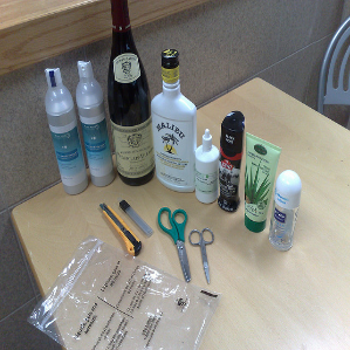

{'<DETAILED_CAPTION>': 'In this image we can see a table. On the table there are bottles, scissor, nail cutter and a cover. To the right side of the image there is a chair.'}


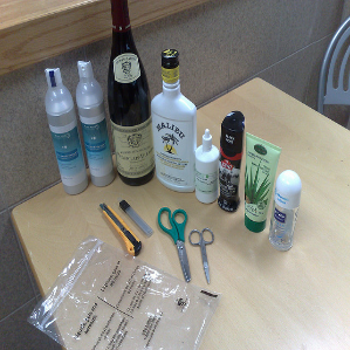

In [21]:
for idx in range(1):
  print(run_example("DocVQA", 'What do you see in this image?', tensor_to_image(data['image_tensor'])))
  display(tensor_to_image(data['image_tensor']).resize([350, 350]))

for idx in range(1):
  print(run_example("<DETAILED_CAPTION>", '', tensor_to_image(data['image_tensor'])))
  display(tensor_to_image(data['image_tensor']).resize([350, 350]))


We need to construct our dataset. Note how we are adding a new task prefix `<DocVQA>` before the question when constructing the prompt.

In [22]:
from torch.utils.data import Dataset

class DocVQADataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        example = self.data[idx]
        question = "<DocVQA>" + example['question']
        first_answer = example['answers'][0]
        image = example['image']
        if image.mode != "RGB":
            image = image.convert("RGB")
        return question, first_answer, image


In [23]:
from torch.utils.data import Dataset

class TFtoPyTorchDataset(Dataset):
    def __init__(self, tf_dataset):
        self.tf_dataset = tf_dataset

    def __len__(self):
        return len(self.tf_dataset)

    def __getitem__(self, idx):
        # Convert TensorFlow tensor to PyTorch tensor
        tf_item = next(iter(self.tf_dataset.skip(idx).take(1)))

        # Process image
        image_tensor = tf_item['image_tensor'].numpy()
        if image_tensor.max() <= 1.0:
            image_tensor = (image_tensor * 255).astype(np.uint8)
        image = Image.fromarray(image_tensor)
        if image.mode != "RGB":
            image = image.convert("RGB")

        # Process caption
        caption = tf_item['caption'].numpy().decode('utf-8')

        # Create a dummy question (since your dataset doesn't have questions)
        question = "<DocVQA>Describe this image"

        return question, caption, image


In [ ]:
! wget http://images.cocodataset.org/zips/train2014.zip
! wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip
! sudo apt-get install unzip
! unzip train2014.zip -d coco
! unzip annotations_trainval2014.zip -d coco

In [2]:
import pandas as pd
import os
import json


class DatasetLoader:

    def init(self, folder_name: str = "coco"):
        self.data = self.load_data(folder_name)

    def load_data(self, folder_name: str = "coco"):
        print("Loading data..")
        # Set the data folder
        data_folder = os.path.join(folder_name)

        # Create the directory if it doesn't exist
        if not os.path.exists(data_folder):
            os.makedirs(data_folder)

        # Path to the captions JSON file
        filename = os.path.join(data_folder, "annotations", "captions_train2014.json")

        # Read and parse the JSON file
        with open(filename, "r") as json_file:
            data = json.load(json_file)

        print("Data loaded succesfully!")

        return data

    def get_data_dict(self):
        return self.data

    def get_df_annotations(self):
        return pd.DataFrame(self.data["annotations"])

    def get_df_images(self):
        return pd.DataFrame(self.data["images"])

# Load the dataset
dataset = DatasetLoader().load_data(folder_name=os.path.join(os.getcwd(), "coco"))

Loading data..
Data loaded succesfully!


In [3]:
def load_captions_data(dataset):
    text_annotations = []

    # Create a mapping from image_id to file_name
    image_id_to_file_name = {image["id"]: image["file_name"] for image in dataset["images"]}

    # Create a mapping from image_id to captions
    image_id_to_captions = {}
    for annotation in dataset["annotations"]:
        image_id = annotation["image_id"]
        caption = annotation["caption"]

        if image_id not in image_id_to_captions:
            image_id_to_captions[image_id] = []

        image_id_to_captions[image_id].append(caption)
        text_annotations.append(caption)

    # Create a combined dictionary with image file names and their corresponding captions
    file_name_to_captions = {
        image_id_to_file_name[image_id]: captions
        for image_id, captions in image_id_to_captions.items()
    }

    return file_name_to_captions, text_annotations


def train_val_split(caption_data, train_size=0.8, shuffle=True):
    """Split the captioning dataset into train and validation sets.

    Args:
        caption_data (dict): Dictionary containing the mapped caption data
        train_size (float): Fraction of all the full dataset to use as training data
        shuffle (bool): Whether to shuffle the dataset before splitting

    Returns:
        Traning and validation datasets as two separated dicts
    """

    # 1. Get the list of all image names
    all_images = list(caption_data.keys())

    # 2. Shuffle if necessary
    if shuffle:
        np.random.shuffle(all_images)

    # 3. Split into training and validation sets
    train_size = int(len(caption_data) * train_size)

    training_data = {
        img_name: caption_data[img_name] for img_name in all_images[:train_size]
    }
    validation_data = {
        img_name: caption_data[img_name] for img_name in all_images[train_size:]
    }

    # 4. Return the splits
    return training_data, validation_data

# Load the dataset
captions_mapping, text_data = load_captions_data(dataset)

# # Split the dataset into training and validation sets
# train_data, valid_data = train_val_split(captions_mapping)
# print("Number of training samples: ", len(train_data))
# print("Number of validation samples: ", len(valid_data))

In [ ]:
captions_mapping

In [44]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import os
import random

class COCOPyTorchDataset(Dataset):
    def __init__(self, captions_mapping, img_dir, transform=None):
        self.captions_mapping = captions_mapping
        self.img_dir = img_dir
        self.transform = transform
        self.img_names = list(captions_mapping.keys())

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        img_path = os.path.join(self.img_dir, img_name)

        # Load and process image
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        # Process image
        # image_tensor = image.numpy()
        # if image_tensor.max() <= 1.0:
        #     image_tensor = (image_tensor * 255).astype(np.uint8)
        # image = Image.fromarray(image_tensor)
        # if image.mode != "RGB":
        #     image = image.convert("RGB")

        # Get caption
        captions = self.captions_mapping[img_name]
        caption = random.choice(captions)  # Randomly select one caption if there are multiple

        # Create a dummy question (since your dataset doesn't have questions)
        question = "<DocVQA>Describe this image"

        return question, caption, image


In [45]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
])

dataset_cocopyTorchDataset = COCOPyTorchDataset(
    captions_mapping=captions_mapping,  # or valid_data for validation set
    img_dir=os.path.join(os.getcwd(), "coco", "train2014"),
    transform=transform
)

In [46]:
dataset_cocopyTorchDataset

In [47]:
# import json
# import os
# from typing import List, Dict, Any, Tuple
# from PIL import Image
# from torch.utils.data import Dataset, DataLoader
# from transformers import ProcessorMixin

# class CustomDataset(Dataset):
#     def init(self, data: Dict[str, List[str]], image_directory_path: str):
#         self.data = data
#         self.image_directory_path = image_directory_path
#         self.image_filenames = list(data.keys())

#     def len(self) -> int:
#         return len(self.image_filenames)

#     def getitem(self, idx: int) -> Tuple[Image.Image, str]:
#         if idx < 0 or idx >= len(self.image_filenames):
#             raise IndexError("Index out of range")

#         image_filename = self.image_filenames[idx]
#         image_path = os.path.join(self.image_directory_path, image_filename)
#         captions = self.data[image_filename]

#         try:
#             image = Image.open(image_path)
#             # Randomly select one caption from the list
#             caption = captions[idx % len(captions)]
#             return image, caption
#         except FileNotFoundError:
#             raise FileNotFoundError(f"Image file {image_path} not found.")

# def collate_fn(batch):
#     images, captions = zip(*batch)
#     inputs = processor(text=list(captions), images=list(images), return_tensors="pt", padding=True).to(DEVICE)
#     return inputs

# # Assuming you have 'train_data' and 'valid_data' variables with the structure you provided
# BATCH_SIZE = 1
# NUM_WORKERS = 0

# train_dataset = CustomDataset(
#     data=train_data,
#     image_directory_path=os.path.join(os.getcwd(), "coco", "train2014")
# )
# val_dataset = CustomDataset(
#     data=valid_data,
#     image_directory_path=os.path.join(os.getcwd(), "coco", "train2014")
# )

# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=NUM_WORKERS, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=NUM_WORKERS)

Let's get to fine-tuning. We will create our dataset, the data collator, and start training. In A100 with 40GB memory, we can fit in 6 examples. If you're training on T4, you can use batch size of 1.

In [48]:
trainds

NameError: name 'trainds' is not defined

In [ ]:
# import os
# from torch.utils.data import DataLoader
# from tqdm import tqdm
# from transformers import (AdamW, AutoProcessor, get_scheduler)

# def collate_fn(batch):
#     questions, answers, images = zip(*batch)
#     inputs = processor(text=list(questions), images=list(images), return_tensors="pt", padding=True).to(device)
#     return inputs, answers

# # Create datasets
# train_dataset = DocVQADataset(data['train'])
# val_dataset = DocVQADataset(data['validation'])

# # Create DataLoader
# batch_size = 6
# num_workers = 0

# train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn, num_workers=num_workers, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn, num_workers=num_workers)

In [49]:
import os
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import (AdamW, AutoProcessor, get_scheduler)

# def collate_fn(batch):
#     questions, answers, images = zip(*batch)
#     inputs = processor(text=list(questions), images=list(images), return_tensors="pt", padding=True).to(device)
#     return inputs, answers

# # Create datasets
# train_dataset = TFtoPyTorchDataset(data['train'])
# val_dataset = TFtoPyTorchDataset(data['validation'])

# # Create DataLoader
# batch_size = 6
# num_workers = 0

# train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn, num_workers=num_workers, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn, num_workers=num_workers)

In [50]:
import tensorflow as tf
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import numpy as np

def collate_fn(batch):
    questions, captions, images = zip(*batch)
    inputs = processor(text=list(questions), images=list(images), return_tensors="pt", padding=True)
    return inputs, captions

# Create dataset
# full_dataset = TFtoPyTorchDataset(trainds)
full_dataset = dataset_cocopyTorchDataset

# Perform train-val split
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

print(f"Full dataset size: {len(full_dataset)}")
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")


# Create DataLoaders
batch_size = 1
num_workers = 0

train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn, num_workers=num_workers, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn, num_workers=num_workers)

Full dataset size: 82783
Training set size: 66226
Validation set size: 16557


In [51]:
def train_model(train_loader, val_loader, model, processor, epochs=10, lr=1e-6):
    print(f"[LOG] Training model for {epochs} epochs")
    optimizer = AdamW(model.parameters(), lr=lr)
    num_training_steps = epochs * len(train_loader)
    print(f"[LOG] Total training steps: {num_training_steps}")
    lr_scheduler = get_scheduler(
        name="linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps,
    )
    print("[LOG] Starting training...")

    for epoch in range(epochs):
        print(f"[LOG] Epoch {epoch + 1}/{epochs}")
        model.train()
        # print("[LOG] After model.train()")
        train_loss = 0
        i = -1
        for batch in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{epochs}"):
        # for batch in train_loader:
            i += 1

            # print(f"[LOG] {i}th batch, len(batch): {len(batch)}, type(batch): {type(batch)}, str(batch): {str(batch)}")
            inputs, answers = batch
            # print(f"[LOG] {i}th batch\n inputs: {inputs}\n answers: {answers}")
            input_ids = inputs["input_ids"].to(device)
            pixel_values = inputs["pixel_values"].to(device)
            labels = processor.tokenizer(text=answers, return_tensors="pt", padding=True, return_token_type_ids=False).input_ids.to(device)

            outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
            loss = outputs.loss

            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        print(f"Average Training Loss: {avg_train_loss}")

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}/{epochs}"):
                inputs, answers = batch

                input_ids = inputs["input_ids"]
                pixel_values = inputs["pixel_values"]
                labels = processor.tokenizer(text=answers, return_tensors="pt", padding=True, return_token_type_ids=False).input_ids.to(device)

                outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
                loss = outputs.loss

                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        print(f"Average Validation Loss: {avg_val_loss}")

        # Save model checkpoint
        output_dir = f"./model_checkpoints/epoch_{epoch+1}"
        os.makedirs(output_dir, exist_ok=True)
        model.save_pretrained(output_dir)
        processor.save_pretrained(output_dir)


After training, we will push the model to Hugging Face Hub. To do so, we need to login first with write access. Make sure to pass either write token or fine-grained token (by first creating the repository and setting up fine-grained token access).

In [52]:
# from huggingface_hub import notebook_login

# notebook_login()

In [53]:
# # prompt: can you iterate on train_loader 3 times?

# i = 0
# for batch in train_loader:
#   i += 1
#   if i == 3:
#     break
#   print(batch)


We will freeze image encoder for this tutorial. The authors have reported improvement in unfreezing image encoder, but note that this will result in more resource usage.

In [54]:
for param in model.vision_tower.parameters():
  param.is_trainable = False

In [ ]:
train_model(train_loader, val_loader, model, processor, epochs=1)

[LOG] Training model for 1 epochs
[LOG] Total training steps: 66226
[LOG] Starting training...
[LOG] Epoch 1/1


Training Epoch 1/1:   0%|          | 185/66226 [02:08<13:18:34,  1.38it/s]

You can push the model like below. You can find the fully fine-tuned DocVQA model [here](https://huggingface.co/HuggingFaceM4/Florence-2-DocVQA). You can find the demo [here](https://huggingface.co/spaces/andito/Florence-2-DocVQA).

Read more about Florence-2 and fine-tuning it [here](https://huggingface.co/blog/finetune-florence2).

In [ ]:
model.push_to_hub("HuggingFaceM4/Florence-2-FT-DocVQA")
processor.push_to_hub("HuggingFaceM4/Florence-2-FT-DocVQA")